# Plate Generator Notebook
### This notebook will demonstrate and execute the generation of synthetic license plates

In [45]:
# We will begin by importing necessary modules

import os
import random
from PIL import Image, ImageDraw, ImageFont, ImageFilter, ImageChops, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import qrcode
import uuid
import random
import string
from PIL import Image

# Since we will be generating this on Google Colab, let's define the paths for our assets as well to make changing these later on easier.

documentation_dir = "documentation"
fonts_dir = "fonts"
images_dir = "images"

The generation process begins with selecting the style for the plate, including color palette and plate background.
We will be basing our choices on the Wikipedia page on Philippine License Plates: https://en.wikipedia.org/wiki/Vehicle_registration_plates_of_the_Philippines.

<figure>
  <img src="documentation/philippine_license_plates.jpg" alt="Philippine License Plates Color Palettes" width="300" />
  <figcaption>Fig 1. Philippine License Plates Color Palettes</figcaption>
</figure>

<figure>
  <img src="documentation/private_passenger_plates.jpg" alt="Private and Passenger License Plates" width="300" />
  <figcaption>Fig 2. Private and Passenger License Plates</figcaption>
</figure>

## Plate Styles
### Plates follow certain formats and color palettes. For the generation step later, it will be useful to have these gathered as one array so we can randomly choose.

In [46]:
# The plate generation process starts by selecting a style for our plates.
# This block defines the various styles that a license plate may have.

# DEFAULT COLORS --------------------------------
# general
black = (0, 0, 0)
white = (255, 255, 255)
# vehicles
v_green = (3, 105, 55)
v_yellow = (246, 196, 13)
v_red = (249, 0, 0)
v_maroon = (134, 0, 0)
v_blue = (6, 41, 100)
# motorcycles
m_pink = (201, 100, 206)
m_green = (0, 123, 95)
m_gray = (119, 111, 103)
m_sky_blue = (106, 179, 230)
m_dark_blue = (47, 0, 140)
m_orange = (227, 82, 5)
m_red = (200, 16, 46)
m_brown = (139, 56, 26)
# government
g_blue = (10, 71, 173)
# rizal background (special case)
r_green = (21, 109, 82)
r_background = os.path.join(images_dir, "plate_backgrounds", "rizal.png")

# LICENSE PLATE STYLES --------------------------------
plate_styles = [
    # type, color1, color2
    ("vehicle", white, black),
    ("vehicle", white, v_green),
    ("vehicle", v_yellow, black),
    ("vehicle", white, v_red),
    ("vehicle", white, v_blue),
    ("motorcycle", white, black),
    ("motorcycle", white, m_pink),
    ("motorcycle", white, m_green),
    ("motorcycle", white, m_gray),
    ("motorcycle", white, m_sky_blue),
    ("motorcycle", white, m_dark_blue),
    ("motorcycle", white, m_orange),
    ("motorcycle", white, m_red),
    ("motorcycle", white, m_brown),
    ("government", g_blue, black),
    ("motorcycle_beveled", white, black),
    ("motorcycle_beveled", v_yellow, black),
    ("motorcycle_beveled", white, v_maroon),
    ("rizal", None, r_green),
]


## Plate Base
### This block creates the base for our plates without the text and obscurations.

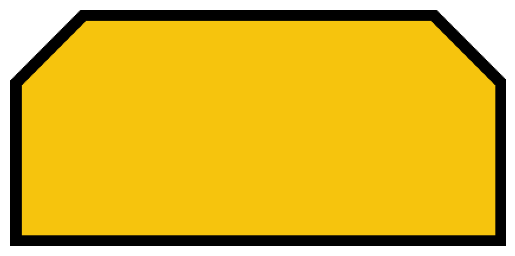

In [47]:
# Next, we will define the function that creates the base for our plates

# scale for debugging
debug_scale = 2
# vehicle
vw, vh = 280*debug_scale, 100*debug_scale
# motorcycle
mw, mh = 175*debug_scale, 100*debug_scale
# motorcycle beveled
maw, mah = 210*debug_scale, 100*debug_scale
corner = 30*debug_scale

def create_plate_base(width, height, border_color, fill_color, border_thickness=5, has_bevel=False):
    img = Image.new('RGBA', (width, height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(img)
    
    b_color = border_color + (255,)
    f_color = fill_color + (255,)
    bt = border_thickness*debug_scale

    if has_bevel:
        # Calculate offset to keep visual thickness uniform on diagonal
        # Math: The shift along the axis = bt * (sqrt(2) - 1)
        shift = int(bt * (math.sqrt(2) - 1))
        
        # 1. Outer Polygon
        outer_points = [
            (0, corner),                # TL Bevel Start
            (corner, 0),                # TL Bevel End
            (width - corner, 0),        # TR Bevel Start
            (width, corner),            # TR Bevel End
            (width, height),            # BR
            (0, height)                 # BL
        ]
        
        # 2. Inner Polygon
        # We inset by 'bt' for straights, and 'corner + shift' for bevel intersections
        inner_points = [
            (bt, corner + shift),               
            (corner + shift, bt),               
            (width - corner - shift, bt),       
            (width - bt, corner + shift),       
            (width - bt, height - bt),          
            (bt, height - bt)                   
        ]
        
    else:
        # Standard Rectangle
        outer_points = [
            (0, 0), (width, 0), (width, height), (0, height)
        ]
        inner_points = [
            (bt, bt), (width - bt, bt), (width - bt, height - bt), (bt, height - bt)
        ]

    draw.polygon(outer_points, fill=b_color)
    draw.polygon(inner_points, fill=f_color)

    return img

def plot_image(img):
    if img.mode == 'L':
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.show()
    
plot_image(create_plate_base(maw, mah, black, v_yellow, has_bevel=True))

## Text Layer
For later annotation, taking note of the letter positions will become extremely important. We'll take note of the letter segments in this implementation.

To start, we'll set up our fonts and scaling utilities.

In [48]:
# Let's define our fonts first

fonts = [
    os.path.join(fonts_dir, f)
    for f in os.listdir(fonts_dir)
    if f.lower().endswith((".ttf", ".otf"))
]

from PIL import Image, ImageDraw, ImageFont

font_scaling = 0.92

Because we want our text to fit nicely within the plate dimensions, we will create a utility function that scales the font size accordingly.

The plan later on is to manipulate the letters as bitmap masks, hence the implementation shown here.


In [49]:
def get_scaled_font(draw, font_path, text, width, height, initial_size=10, step=2):
    """
    Returns the scaled ImageFont object that fits within width/height constraints.
    """
    max_width, max_height = width * font_scaling, height * font_scaling
    size = initial_size

    while True:
        font_obj = ImageFont.truetype(font_path, size)
        bbox = draw.textbbox((0, 0), text, font=font_obj)
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]

        if w > max_width or h > max_height:
            break
        size += step

    return ImageFont.truetype(font_path, size - step)


The reason I approached the plate text on a letter-by-letter basis was because we can just convert these into polygons later on.

I've prepared assets to simulate paint chipping, found in images\obscurations_letter. So I also need a method that applies these masks onto an individual letter image.

In [50]:
# polygon from mask

def get_polygon_from_mask(mask):
    mask_array = np.array(mask)

    contours, _ = cv2.findContours(
        mask_array,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    polygons = []
    for cnt in contours:
        if cv2.contourArea(cnt) > 1:  # ignore tiny specks
            poly_points = cnt.reshape(-1, 2).tolist()
            polygons.append(poly_points)

    return polygons

# paint chipping config

chip_dir = os.path.join(images_dir, "obscurations_letter")

chip_mask_files = [
    os.path.join(chip_dir, f)
    for f in os.listdir(chip_dir)
    if f.lower().endswith((".png", ".jpg"))
]

chipping_probability = 0.5


In [51]:
# paint chipping function

def apply_paint_chipping(letter_image, letter_mask):
    # Only apply chipping with configured probability
    if random.random() > chipping_probability:
        return letter_image

    bbox = letter_mask.getbbox()
    if not bbox:
        return letter_image  # No letter found in mask

    chip_mask_path = random.choice(chip_mask_files)
    chip_mask = Image.open(chip_mask_path).convert("L")

    letter_width = bbox[2] - bbox[0]
    letter_height = bbox[3] - bbox[1]

    # Resize chip mask to relative size
    scale_factor = random.uniform(0.3, 0.7)
    chip_width = int(letter_width * scale_factor)
    chip_height = int(letter_height * scale_factor)

    chip_mask = chip_mask.resize((chip_width, chip_height), Image.Resampling.LANCZOS)

    placement_mask = Image.new("L", letter_image.size, 0)

    max_x = bbox[0] + letter_width - chip_width
    max_y = bbox[1] + letter_height - chip_height

    if max_x <= bbox[0] or max_y <= bbox[1]:
        return letter_image  # Letter too small for chipping

    pos_x = random.randint(bbox[0], max_x)
    pos_y = random.randint(bbox[1], max_y)

    placement_mask.paste(chip_mask, (pos_x, pos_y))

    # Apply chipping by changing alpha where placement mask is white
    text_layer_rgba = letter_image.convert("RGBA")

    alpha = text_layer_rgba.split()[3]
    alpha_array = np.array(alpha)
    chip_array = np.array(placement_mask)

    alpha_array[chip_array > 128] = 0

    new_alpha = Image.fromarray(alpha_array)
    r, g, b, _ = text_layer_rgba.split()
    result = Image.merge("RGBA", (r, g, b, new_alpha))

    return result


Now, I can create the actual text layer. 
The paint chipping allows for letter-level obscurations.
The polygon annotation will help verifying the bitmap masks' locations.

In [52]:
def create_text_layer(font_path, text, width, height, fill_color, enable_paint_chipping=False):
    """
    Draws each letter individually and returns:
      { "image": Image(RGBA), "annotations": [ {"character": char, "mask": Image(L)} ... ] }
    """
    text_layer = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    d = ImageDraw.Draw(text_layer)

    # Get scaled font for the full text block
    font_obj = get_scaled_font(d, font_path, text, width, height)

    full_bbox = d.textbbox((0, 0), text, font=font_obj)
    total_w = full_bbox[2] - full_bbox[0]
    total_h = full_bbox[3] - full_bbox[1]

    current_x = (width - total_w) // 2
    y_pos = (height - total_h) // 2 - full_bbox[1]

    letter_bitmap_annotations = []

    for char in text:
        # A. create per-char mask
        char_mask = Image.new("L", (width, height), 0)
        mask_d = ImageDraw.Draw(char_mask)
        mask_d.text((current_x, y_pos), char, font=font_obj, fill=255)
        letter_bitmap_annotations.append({"character": char, "mask": char_mask})

        # B. draw visible letter on the main layer
        d.text((current_x, y_pos), char, font=font_obj, fill=fill_color + (255,))

        # C. advance cursor
        char_width = d.textlength(char, font=font_obj)
        current_x += char_width

    # Apply paint chipping per letter if requested
    if enable_paint_chipping:
        for annotation in letter_bitmap_annotations:
            text_layer = apply_paint_chipping(text_layer, annotation["mask"])

    return {"image": text_layer, "annotations": letter_bitmap_annotations}


Here is what the base text looks like without chipping.

Base Text Rendering (no chipping)


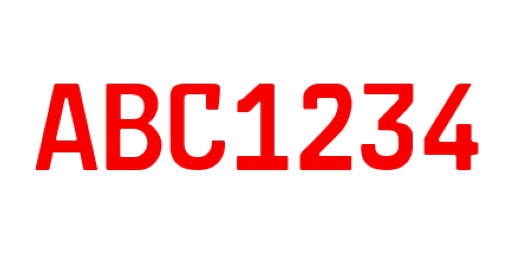

In [53]:
# Cell 7 — Base rendering display (no chipping)
print("Base Text Rendering (no chipping)")
base_text = create_text_layer(
    fonts[0],
    "ABC1234",
    maw,
    mah,
    v_red,
    enable_paint_chipping=False
)
plot_image(base_text["image"])

Now, let's see the per-character masks (or the bitmap masks which we'll convert into annotations later on).

Character Bitmap Annotations
character: A


Character Bitmap Annotations
character: A


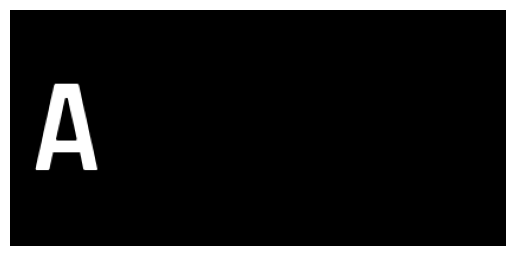

Character Bitmap Annotations
character: A


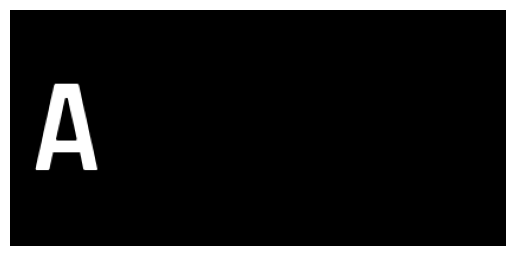

character: B


Character Bitmap Annotations
character: A


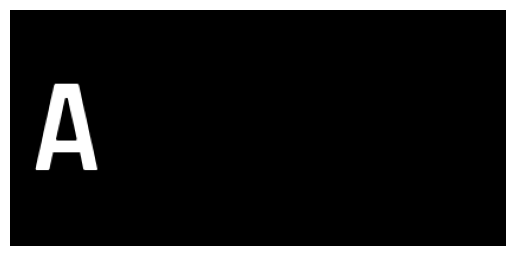

character: B


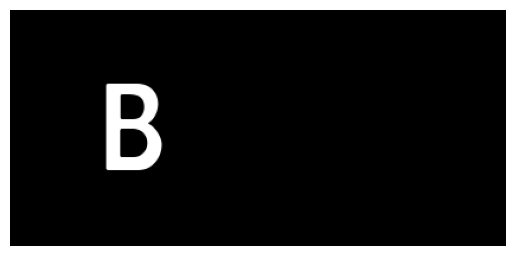

Character Bitmap Annotations
character: A


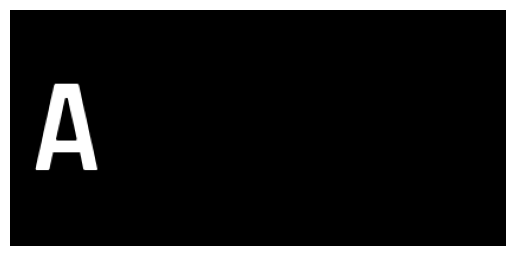

character: B


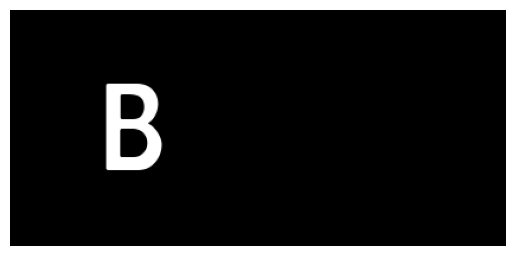

character: C


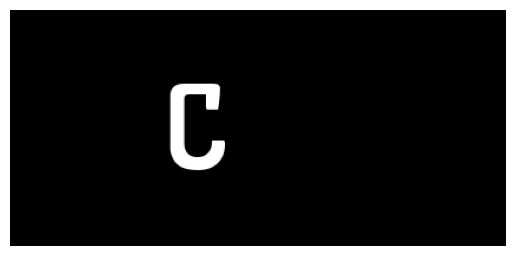

Character Bitmap Annotations
character: A


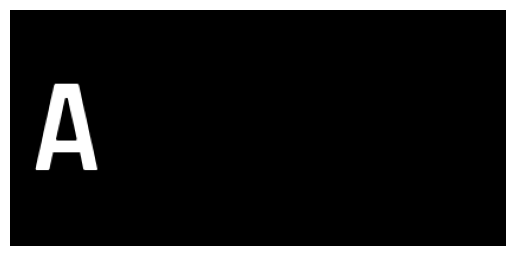

character: B


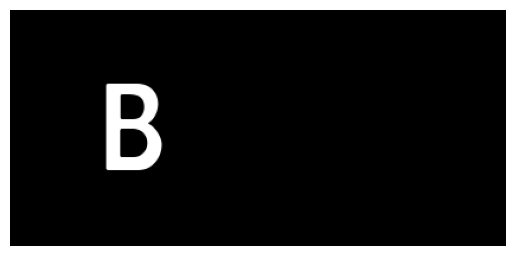

character: C


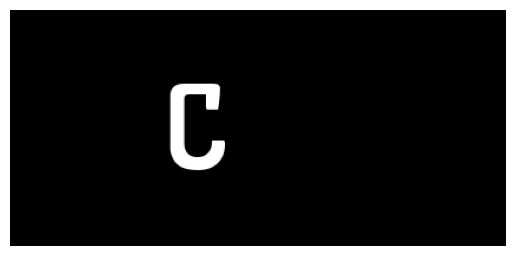

character: 1


Character Bitmap Annotations
character: A


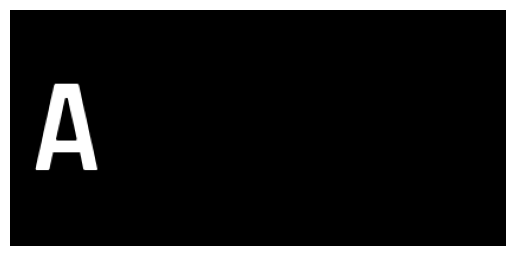

character: B


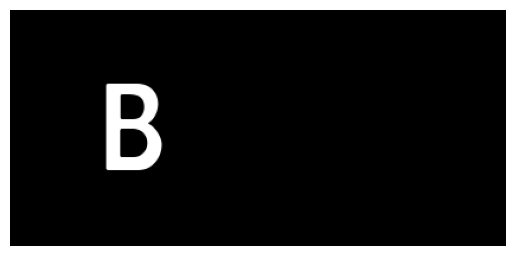

character: C


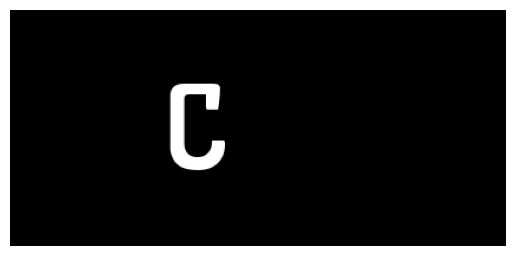

character: 1


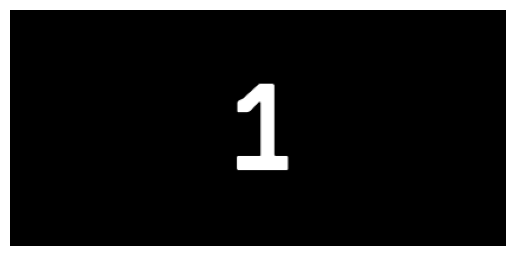

character: 2


Character Bitmap Annotations
character: A


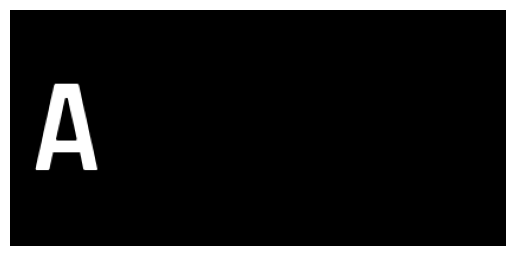

character: B


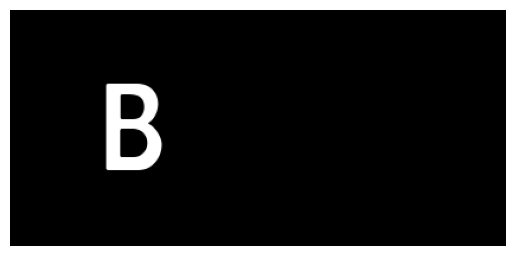

character: C


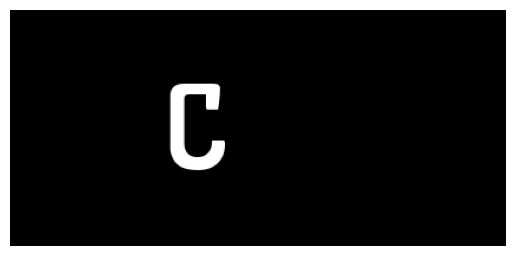

character: 1


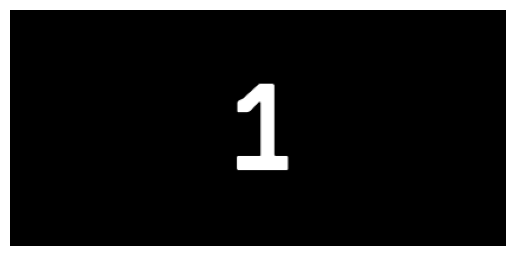

character: 2


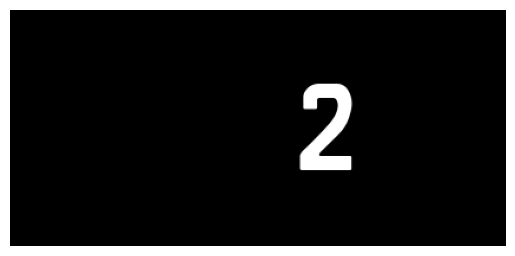

Character Bitmap Annotations
character: A


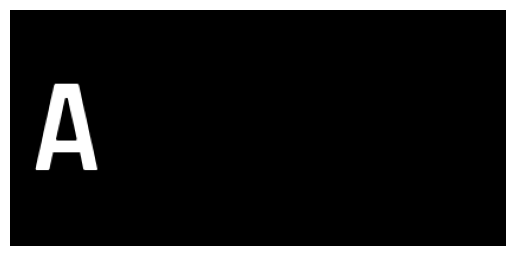

character: B


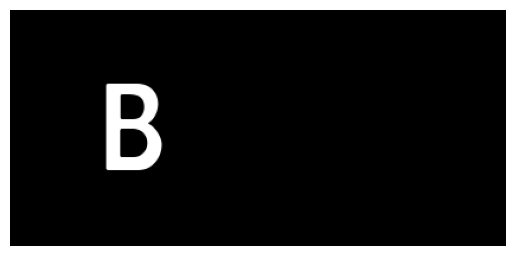

character: C


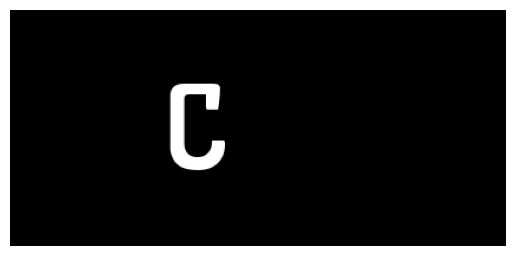

character: 1


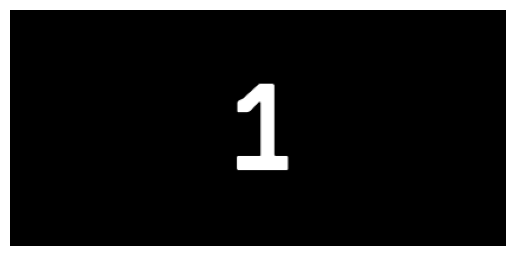

character: 2


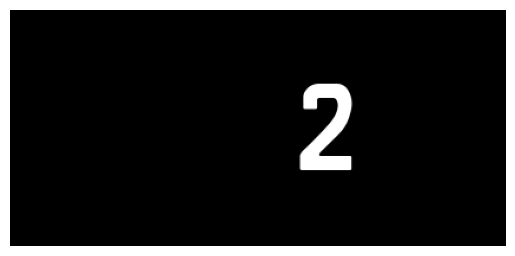

character: 3


Character Bitmap Annotations
character: A


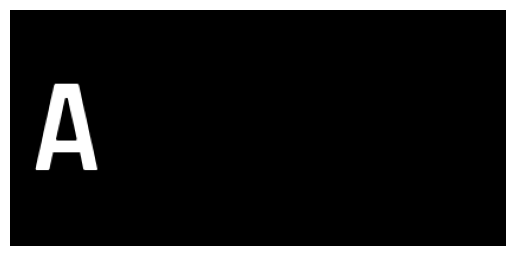

character: B


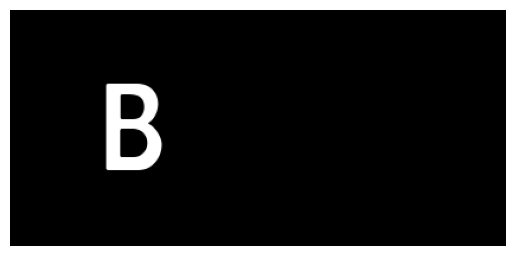

character: C


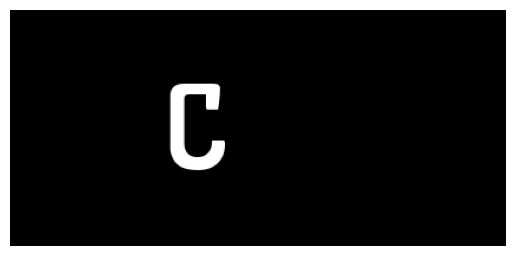

character: 1


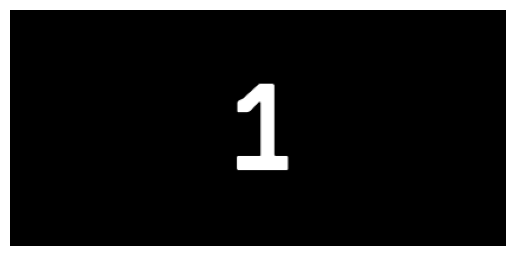

character: 2


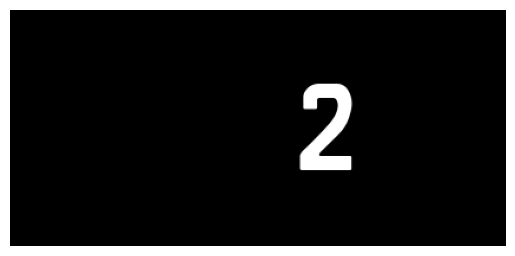

character: 3


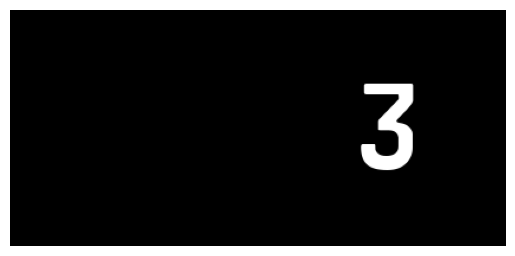

Character Bitmap Annotations
character: A


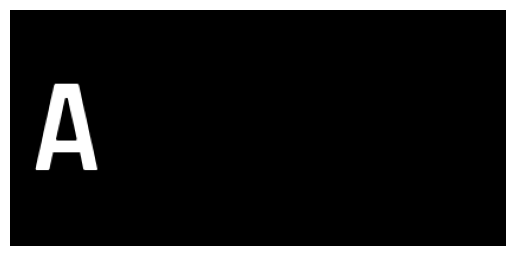

character: B


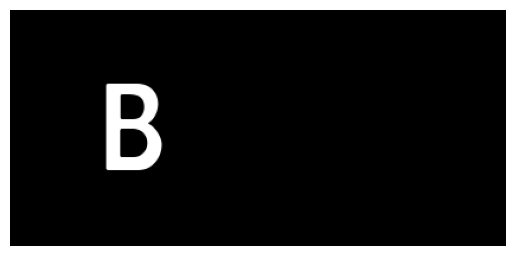

character: C


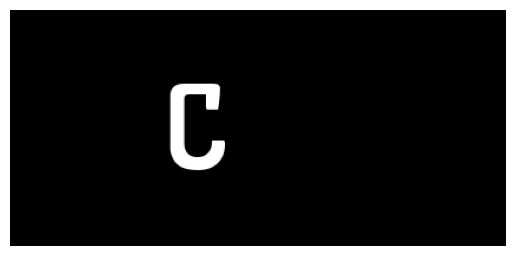

character: 1


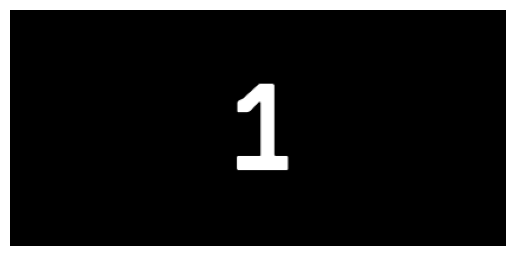

character: 2


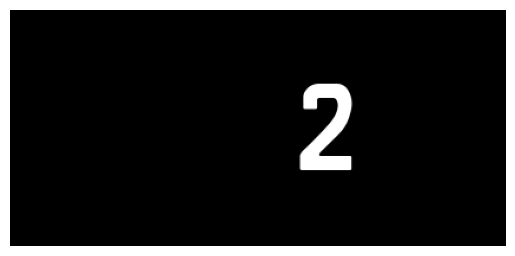

character: 3


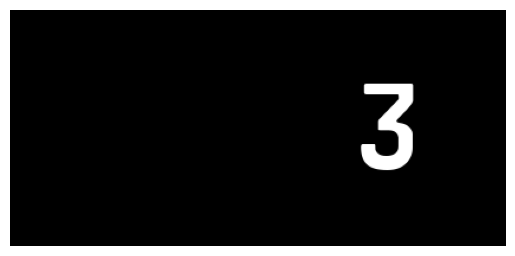

character: 4


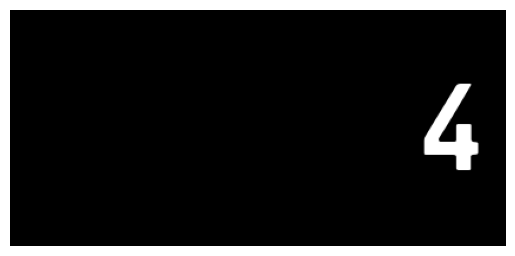

In [54]:
print("Character Bitmap Annotations")
for annotation in base_text["annotations"]:
    print("character:", annotation["character"])
    plot_image(annotation["mask"])

And here's what a license plate looks like with paint chipping.

Text Rendering with Paint Chipping


Text Rendering with Paint Chipping


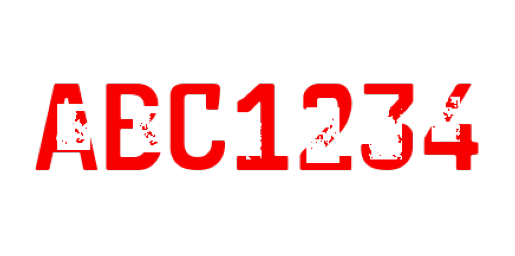

In [55]:
print("Text Rendering with Paint Chipping")
chipped_text = create_text_layer(
    fonts[0],
    "ABC1234",
    maw,
    mah,
    v_red,
    enable_paint_chipping=True
)
plot_image(chipped_text["image"])


Now I'll create the polygon conversion and visualization methods.
I'll be affining and transforming these text layers. It's helpful to verify if the annotations are still correct.

Text Layer with Annotation Polygons (chipped)


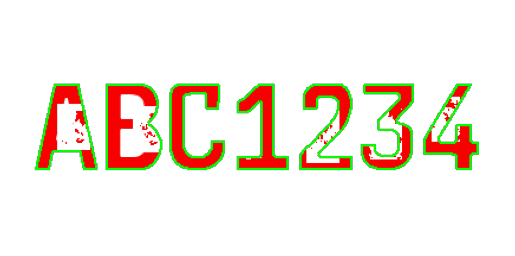

In [56]:
def convert_to_polygons(annotations):
    all_polygons = []
    for annotation in annotations:
        polygons = get_polygon_from_mask(annotation["mask"])
        all_polygons.extend(polygons)
    return all_polygons

def visualize_polygon_overlay(original_image, annotations):
    debug_img = original_image.convert("RGBA").copy()
    all_polygons = convert_to_polygons(annotations)
    d = ImageDraw.Draw(debug_img)
    for poly in all_polygons:
        if not poly:
            continue
        poly_tuples = [tuple(point) for point in poly]
        d.polygon(poly_tuples, outline=(0, 255, 0, 255), width=2)
    return debug_img

print("Text Layer with Annotation Polygons (chipped)")
overlay_img = visualize_polygon_overlay(chipped_text["image"], chipped_text["annotations"])
plot_image(overlay_img)


## Content Layer
### The content layer involves the text layer, but also has a border and smaller text. Emboss is added to enhance realism.
### The border will be added at the template level, so let's focus on the emboss and small text.

Let's start off by defining our emboss utility function.

In [57]:
def apply_random_emboss(layer: Image.Image) -> Image.Image:
    if layer.mode != "RGBA":
        layer = layer.convert("RGBA")

    w, h = layer.size
    alpha = layer.split()[3]

    blur_radius = random.uniform(0.05, 0.3)
    heightmap = alpha.filter(ImageFilter.GaussianBlur(blur_radius))

    angle = random.uniform(0, 2 * math.pi)
    strength = random.uniform(0, 3.5)

    if strength < 0.1:
        return layer

    dx = int(round(math.cos(angle) * strength))
    dy = int(round(-math.sin(angle) * strength))

    light_shift = ImageChops.offset(heightmap, -dx, -dy)
    dark_shift = ImageChops.offset(heightmap, dx, dy)

    highlight = ImageChops.subtract(light_shift, heightmap)
    shadow = ImageChops.subtract(dark_shift, heightmap)

    highlight_strength = random.uniform(1.2, 1.6)
    shadow_strength = random.uniform(0.8, 1.1)

    highlight = highlight.point(lambda p: int(min(255, p * highlight_strength)))
    shadow = shadow.point(lambda p: int(min(255, p * shadow_strength)))

    highlight_col = Image.new("RGBA", (w, h), (255, 255, 255, 0))
    highlight_col.putalpha(highlight)

    shadow_col = Image.new("RGBA", (w, h), (0, 0, 0, 0))
    shadow_col.putalpha(shadow)

    out = Image.alpha_composite(layer, highlight_col)
    out = Image.alpha_composite(out, shadow_col)

    return out


Now a few more auxiliary text helpers.

In [58]:
def generate_dummy_text():
    words = []
    for _ in range(3):
        length = random.randint(3, 5)
        word = ''.join(random.choices(string.ascii_uppercase + string.digits, k=length))
        words.append(word)
    return " ".join(words)

def add_small_text(plate_image, text, position="bottom", font_path=None, color=None):
    if plate_image.mode != "RGBA":
        plate_image = plate_image.convert("RGBA")

    result = plate_image.copy()
    draw = ImageDraw.Draw(result)

    width, height = plate_image.size
    if font_path is None and fonts:
        font_path = random.choice(fonts)

    if position == "bottom":
        max_text_width = int(width * 0.9)
        max_text_height = int(height * 0.15)
        text_x = width // 2
        text_y = height - int(height * 0.05)
    elif position == "top":
        max_text_width = int(width * 0.9)
        max_text_height = int(height * 0.15)
        text_x = width // 2
        text_y = int(height * 0.3)
    else:
        return plate_image

    small_font = get_scaled_font(
        draw, font_path, text,
        max_text_width, max_text_height,
        initial_size=10, step=2
    )

    text_layer = Image.new("RGBA", (width, height), (0, 0, 0, 0))
    td = ImageDraw.Draw(text_layer)
    td.text((text_x, text_y), text, font=small_font, fill=color + (255,), anchor="ms")

    text_layer = apply_random_emboss(text_layer)
    return Image.alpha_composite(result, text_layer)


Emboss Effect Demo

Text with Random Emboss Applied


Emboss Effect Demo

Text with Random Emboss Applied


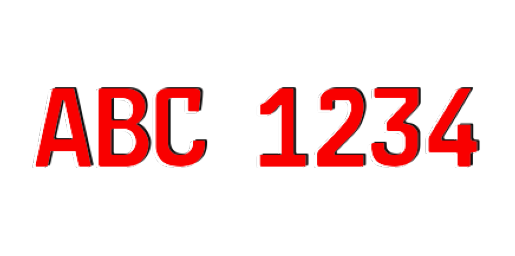

Emboss Effect Demo

Text with Random Emboss Applied


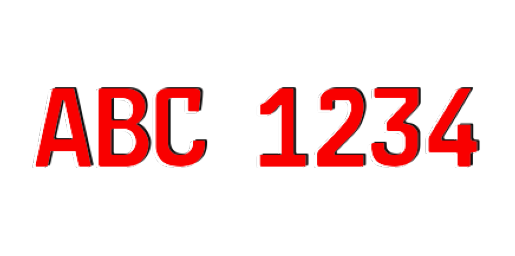


Text with Random Chipping and Emboss Applied


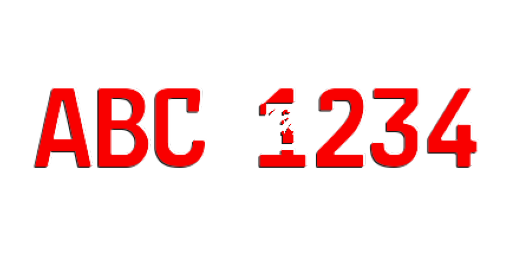

In [59]:
# Demo: Emboss Effect on Text Layer

print("Emboss Effect Demo")

# Create a sample text layer
sample_text = create_text_layer(
    fonts[0],
    "ABC 1234",
    maw,
    mah,
    v_red,
    enable_paint_chipping=False
)

# Apply emboss effect
embossed_text = apply_random_emboss(sample_text["image"])

print("\nText with Random Emboss Applied")
plot_image(embossed_text)

# Create a sample text layer
sample_text = create_text_layer(
    fonts[0],
    "ABC 1234",
    maw,
    mah,
    v_red,
    enable_paint_chipping=True
)

# Apply emboss effect
chipped_and_embossed_text = apply_random_emboss(sample_text["image"])

print("\nText with Random Chipping and Emboss Applied")
plot_image(chipped_and_embossed_text)

In [60]:
# Let's also sample our dummy text generator
print("dummy text samples:")
for _ in range(3):
    print(generate_dummy_text())

dummy text samples:
J2PHL I14Q U04Q3
UIEEW 1R7 WGBO
7VIQ7 UYVKZ 9LMC


## Plate Templates

Using the images aboved as reference, below are four templates for plate generation, namely
- vehicle plates
- motorcycle plates
- beveled motorcycle plates
- rizal plates

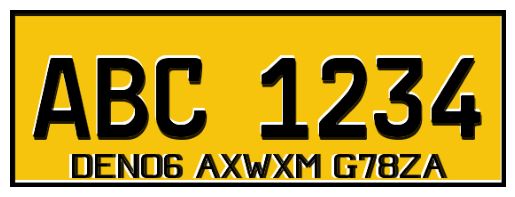

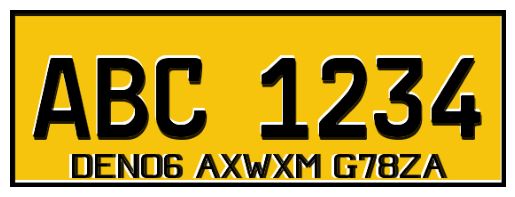

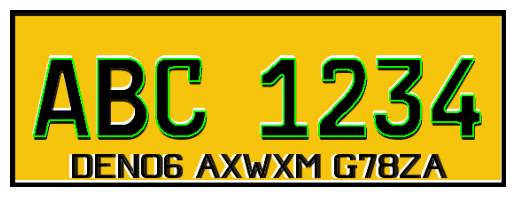

In [61]:
def create_vehicle_plate(color1, color2, font, text,
                         enable_paint_chipping=False,
                         enable_small_text=True):

    base = create_plate_base(vw, vh, color1, color2, border_thickness=0, has_bevel=False)

    content_layer = Image.new("RGBA", (vw, vh), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    for i in range(5):
        d.rectangle([i, i, vw - 1 - i, vh - 1 - i], outline=color1 + (255,))

    text_out = create_text_layer(
        font, text, vw, vh, color1,
        enable_paint_chipping=enable_paint_chipping
    )
    content_layer = Image.alpha_composite(content_layer, text_out["image"])

    content_layer = apply_random_emboss(content_layer)
    plate = Image.alpha_composite(base, content_layer)

    if enable_small_text:
        plate = add_small_text(
            plate,
            generate_dummy_text(),
            position="bottom",
            color=color1
        )

    return {"image": plate, "annotations": text_out["annotations"]}

sample_plate = create_vehicle_plate(black, v_yellow, fonts[0], "ABC 1234")
plot_image(sample_plate["image"])
plot_image(visualize_polygon_overlay(sample_plate["image"], sample_plate["annotations"]))

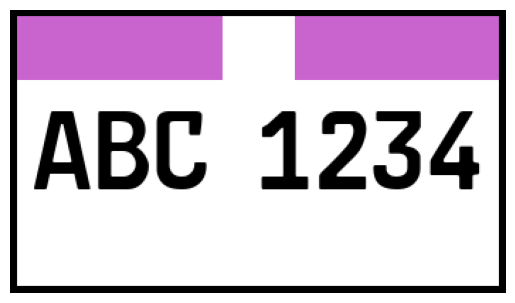

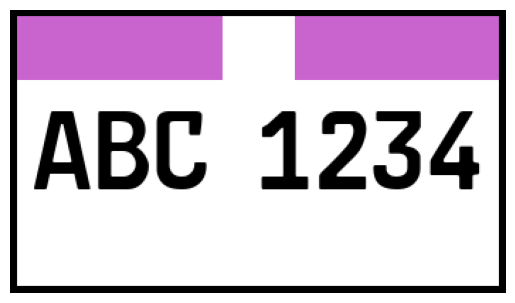

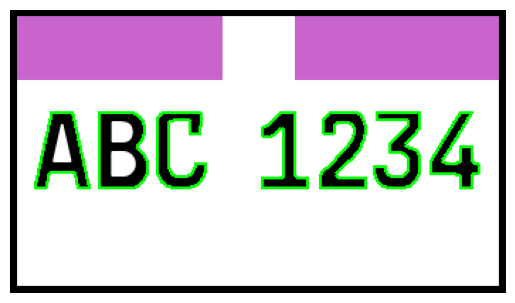

In [62]:
def create_motorcycle_plate(color, font, text,
                            detailOnTop=True,
                            enable_paint_chipping=False):

    base = create_plate_base(mw, mh, black, white, border_thickness=0, has_bevel=False)

    content_layer = Image.new("RGBA", (mw, mh), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    for i in range(5):
        d.rectangle([i, i, mw - 1 - i, mh - 1 - i], outline=black + (255,))

    text_out = create_text_layer(
        font, text, mw, mh, black,
        enable_paint_chipping=enable_paint_chipping
    )
    content_layer = Image.alpha_composite(content_layer, text_out["image"])
    content_layer = apply_random_emboss(content_layer)

    plate = Image.alpha_composite(base, content_layer)

    rect_w, rect_h = int(72 * debug_scale), int(22 * debug_scale)
    offset = 5
    detail_layer = Image.new("RGBA", (mw, mh), (0, 0, 0, 0))
    dd = ImageDraw.Draw(detail_layer)

    if detailOnTop:
        dd.rectangle([offset, offset, offset + rect_w, offset + rect_h], fill=color + (255,))
        dd.rectangle([mw - offset - rect_w, offset, mw - offset, offset + rect_h], fill=color + (255,))
    else:
        dd.rectangle([offset, mh - offset - rect_h, offset + rect_w, mh - offset], fill=color + (255,))
        dd.rectangle([mw - offset - rect_w, mh - offset - rect_h, mw - offset, mh - offset], fill=color + (255,))

    plate = Image.alpha_composite(plate, ImageChops.darker(detail_layer, plate))

    return {"image": plate, "annotations": text_out["annotations"]}


sample_plate = create_motorcycle_plate(m_pink, fonts[0], "ABC 1234")
plot_image(sample_plate["image"])
plot_image(visualize_polygon_overlay(sample_plate["image"], sample_plate["annotations"]))

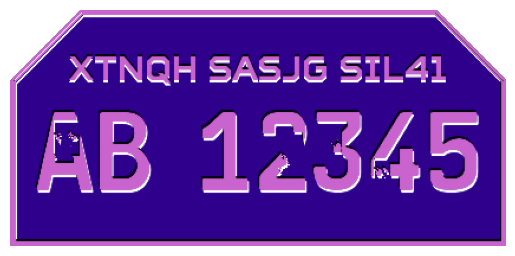

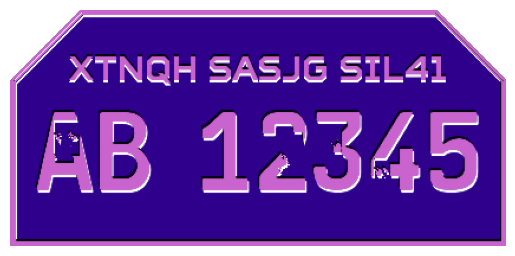

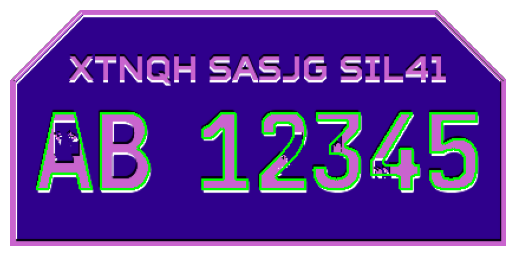

In [63]:
def create_motorcycle_beveled_plate(color1, color2, font, text,
                                    enable_paint_chipping=False,
                                    enable_small_text=True):

    base = create_plate_base(maw, mah, color1, color2, border_thickness=0, has_bevel=True)
    content_layer = Image.new("RGBA", (maw, mah), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    for i in range(5):
        shift = int(i * (math.sqrt(2) - 1))
        poly = [
            (i, corner + shift),
            (corner + shift, i),
            (maw - corner - shift, i),
            (maw - i, corner + shift),
            (maw - i, mah - i),
            (i, mah - i)
        ]
        d.polygon(poly, outline=color1 + (255,))

    text_out = create_text_layer(
        font, text, maw, mah, color1,
        enable_paint_chipping=enable_paint_chipping
    )

    shift_y = int(mah * 0.1)
    shifted_image = Image.new("RGBA", (maw, mah), (0, 0, 0, 0))
    shifted_image.paste(text_out["image"], (0, shift_y), text_out["image"])

    shifted_annotations = []
    for ann in text_out["annotations"]:
        m = Image.new("L", (maw, mah), 0)
        m.paste(ann["mask"], (0, shift_y), ann["mask"])
        shifted_annotations.append({"character": ann["character"], "mask": m})

    text_out["image"] = shifted_image
    text_out["annotations"] = shifted_annotations

    content_layer = Image.alpha_composite(content_layer, shifted_image)
    content_layer = apply_random_emboss(content_layer)

    base_alpha = base.split()[-1]
    content_alpha = content_layer.split()[-1]
    content_layer.putalpha(ImageChops.multiply(content_alpha, base_alpha))

    plate = Image.alpha_composite(base, content_layer)

    if enable_small_text:
        plate = add_small_text(
            plate,
            generate_dummy_text(),
            position="top",
            color=color1
        )

    return {"image": plate, "annotations": text_out["annotations"]}


sample_plate = create_motorcycle_beveled_plate(
    m_pink, m_dark_blue, fonts[0], "AB 12345",
    enable_paint_chipping=True)
plot_image(sample_plate["image"])
plot_image(visualize_polygon_overlay(sample_plate["image"], sample_plate["annotations"]))

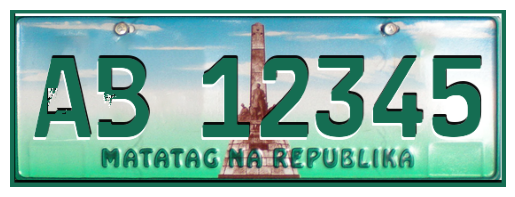

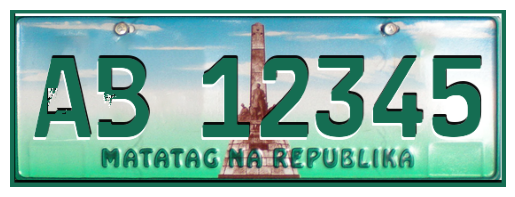

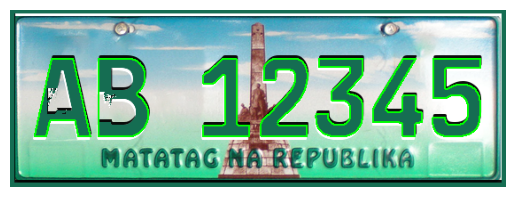

In [64]:
def create_rizal_plate(font, text, enable_paint_chipping=False):
    base = Image.open(r_background).convert("RGBA").resize((vw, vh), Image.Resampling.LANCZOS)

    content_layer = Image.new("RGBA", (vw, vh), (0, 0, 0, 0))
    d = ImageDraw.Draw(content_layer)

    for i in range(5):
        d.rectangle([i, i, vw - 1 - i, vh - 1 - i], outline=r_green + (255,))

    text_out = create_text_layer(
        font, text, vw, vh, r_green,
        enable_paint_chipping=enable_paint_chipping
    )

    content_layer = Image.alpha_composite(content_layer, text_out["image"])
    content_layer = apply_random_emboss(content_layer)

    plate = Image.alpha_composite(base, content_layer)
    return {"image": plate, "annotations": text_out["annotations"]}


sample_plate = create_rizal_plate(
    fonts[0], "AB 12345",
    enable_paint_chipping=True)
plot_image(sample_plate["image"])
plot_image(visualize_polygon_overlay(sample_plate["image"], sample_plate["annotations"]))

## Plate Obscurations
### Let's add one more layer of obscuration. So that the model doesn't overfit on "clean" license plates, I've prepared plate-level obscurations as well.

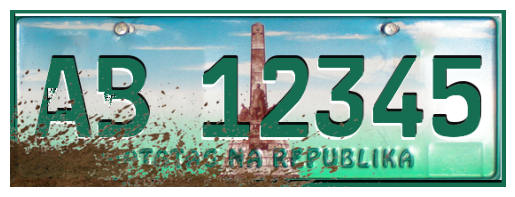

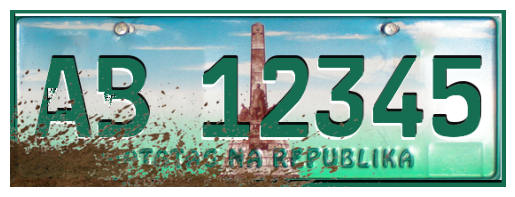

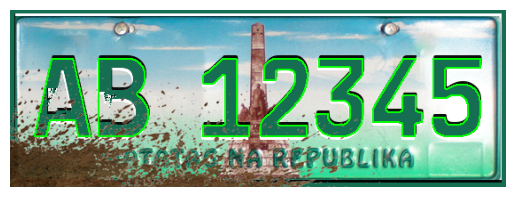

In [65]:
plate_obscurations_dir = os.path.join(images_dir, "obscurations_plate")
plate_obscuration_files = [
    os.path.join(plate_obscurations_dir, f)
    for f in os.listdir(plate_obscurations_dir)
    if f.lower().endswith((".png", ".jpg"))
]

def apply_plate_obscuration(plate_image):
    if not plate_obscuration_files:
        return plate_image
    
    # Convert to RGBA if needed
    if plate_image.mode != "RGBA":
        plate_image = plate_image.convert("RGBA")
    
    # Randomly select an obscuration
    obscuration_path = random.choice(plate_obscuration_files)
    obscuration = Image.open(obscuration_path).convert("RGBA")
    
    # Resize obscuration to match plate dimensions
    obscuration = obscuration.resize(plate_image.size, Image.Resampling.LANCZOS)
    
    # Get the alpha channel of the plate to use as a mask
    plate_alpha = plate_image.split()[3]
    
    # Apply the plate's alpha mask to the obscuration
    # This ensures obscuration only appears on opaque pixels
    r, g, b, a = obscuration.split()
    # Multiply obscuration alpha with plate alpha
    masked_alpha = ImageChops.multiply(a, plate_alpha)
    obscuration_masked = Image.merge("RGBA", (r, g, b, masked_alpha))
    
    # Composite the masked obscuration on top of the plate
    result = Image.alpha_composite(plate_image, obscuration_masked)
    
    return result

# example using the plate above.
plate_img_obscured = apply_plate_obscuration(sample_plate["image"])
plot_image(plate_img_obscured)
plot_image(visualize_polygon_overlay(plate_img_obscured, sample_plate["annotations"]))

## Plate Augmentations
While I'll also perform augmentations during the training loop, manually augmenting the raw dataset (especially for rotation, affining, and motion blur) will help control these parameters.

The first method is for placing our augmented plates onto a 512x12 background.

In [66]:
# Background images used for plate placement
plate_backgrounds_dir = os.path.join(images_dir, "image_backgrounds")

plate_background_files = [
    os.path.join(plate_backgrounds_dir, f)
    for f in os.listdir(plate_backgrounds_dir)
    if f.lower().endswith((".png", ".jpg"))
]

def plate_on_512x512(plate_image, annotations, scale=1.0, enable_random_background=False):
    target_size = (512, 512)

    if enable_random_background:
        bg_file = random.choice(plate_background_files)
        background = Image.open(bg_file).convert("RGBA").resize(
            target_size, Image.Resampling.LANCZOS
        )
    else:
        background = Image.new("RGBA", target_size, (0, 0, 0, 0))

    max_plate_w = int(target_size[0] * 0.8 * scale)
    max_plate_h = int(target_size[1] * 0.4 * scale)

    plate_w, plate_h = plate_image.size
    scale_factor = min(
        max_plate_w / plate_w,
        max_plate_h / plate_h,
        1.0
    )

    new_w = int(plate_w * scale_factor)
    new_h = int(plate_h * scale_factor)

    plate_resized = plate_image.resize((new_w, new_h), Image.Resampling.LANCZOS)

    pos_x = random.randint(0, target_size[0] - new_w)
    pos_y = random.randint(0, target_size[1] - new_h)

    result = background.copy()
    result.paste(plate_resized, (pos_x, pos_y), plate_resized)

    transformed_annotations = []
    for ann in annotations:
        resized_mask = ann["mask"].resize((new_w, new_h), Image.Resampling.LANCZOS)
        mask_canvas = Image.new("L", target_size, 0)
        mask_canvas.paste(resized_mask, (pos_x, pos_y))
        transformed_annotations.append({
            "character": ann["character"],
            "mask": mask_canvas
        })

    return {"image": result, "annotations": transformed_annotations}


For Perspective:

Perspective Warp


Perspective Warp


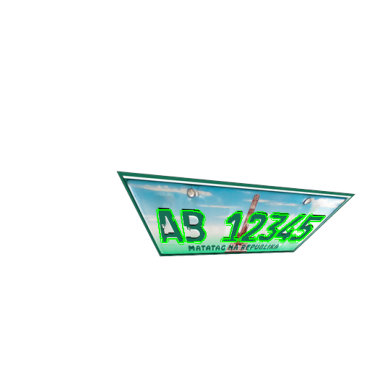

In [67]:
def perspective_transform(image, annotations, max_warp=0):
    width, height = image.size
    img_array = np.array(image)

    max_displacement = int(max(max_warp * width, max_warp * height))
    canvas_width = width + 2 * max_displacement
    canvas_height = height + 2 * max_displacement

    original_points = np.float32([
        [max_displacement, max_displacement],
        [width + max_displacement, max_displacement],
        [width + max_displacement, height + max_displacement],
        [max_displacement, height + max_displacement]
    ])

    def perturb_point(x, y):
        return [
            x + random.uniform(-max_warp * width, max_warp * width),
            y + random.uniform(-max_warp * height, max_warp * height)
        ]

    new_points = np.float32([
        perturb_point(*original_points[0]),
        perturb_point(*original_points[1]),
        perturb_point(*original_points[2]),
        perturb_point(*original_points[3])
    ])

    matrix = cv2.getPerspectiveTransform(original_points, new_points)

    channels = img_array.shape[2]
    canvas = np.zeros((canvas_height, canvas_width, channels), dtype=np.uint8)
    canvas[
        max_displacement:max_displacement + height,
        max_displacement:max_displacement + width
    ] = img_array

    warped_image = cv2.warpPerspective(
        canvas,
        matrix,
        (canvas_width, canvas_height),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0, 0)
    )

    warped_annotations = []
    for ann in annotations:
        mask = np.array(ann["mask"])
        mask_canvas = np.zeros((canvas_height, canvas_width), dtype=np.uint8)
        mask_canvas[
            max_displacement:max_displacement + height,
            max_displacement:max_displacement + width
        ] = mask

        warped_mask = cv2.warpPerspective(
            mask_canvas,
            matrix,
            (canvas_width, canvas_height),
            flags=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=0
        )

        warped_annotations.append({
            "character": ann["character"],
            "mask": Image.fromarray(warped_mask)
        })

    return {"image": Image.fromarray(warped_image), "annotations": warped_annotations}

print("Perspective Warp")

out = perspective_transform(
    sample_plate["image"],
    sample_plate["annotations"],
    max_warp=0.2
)

out = plate_on_512x512(out["image"], out["annotations"], scale=1.0)
plot_image(visualize_polygon_overlay(out["image"], out["annotations"]))


For rotation:

Rotation


Rotation


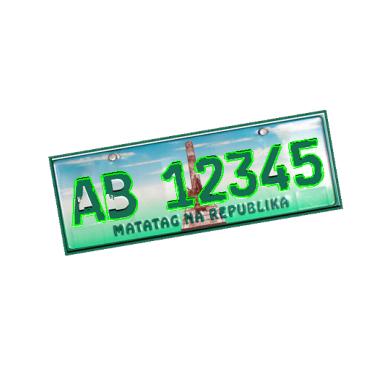

In [68]:
def rotate_transform(image, annotations, max_angle=0):
    angle = random.uniform(-max_angle, max_angle)

    rotated_image = image.rotate(
        angle,
        expand=True,
        resample=Image.Resampling.BICUBIC,
        fillcolor=(0, 0, 0, 0)
    )

    rotated_annotations = []
    for ann in annotations:
        rotated_mask = ann["mask"].rotate(
            angle,
            expand=True,
            resample=Image.Resampling.BICUBIC,
            fillcolor=0
        )
        rotated_annotations.append({
            "character": ann["character"],
            "mask": rotated_mask
        })

    return {"image": rotated_image, "annotations": rotated_annotations}

print("Rotation")

out = rotate_transform(
    sample_plate["image"],
    sample_plate["annotations"],
    max_angle=15
)

out = plate_on_512x512(out["image"], out["annotations"], scale=1.0)
plot_image(visualize_polygon_overlay(out["image"], out["annotations"]))



For motion blur:

Motion Blur


Motion Blur


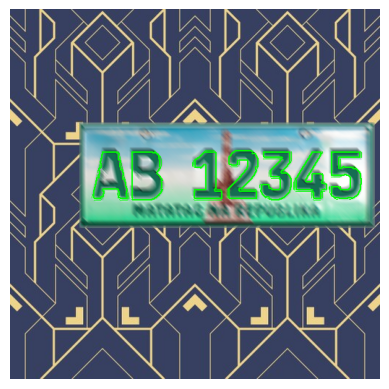

In [69]:
def motion_blur(image, annotations, length=20, angle=0, num_samples=10):
    img_array = np.array(image)
    height, width = img_array.shape[:2]

    angle_rad = np.deg2rad(angle)
    dx = (length * np.cos(angle_rad)) / num_samples
    dy = (length * np.sin(angle_rad)) / num_samples

    accumulated = np.zeros_like(img_array, dtype=np.float32)

    for i in range(num_samples):
        tx = dx * (i - num_samples // 2)
        ty = dy * (i - num_samples // 2)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        shifted = cv2.warpAffine(
            img_array.astype(np.float32),
            M,
            (width, height)
        )
        accumulated += shifted

    result = (accumulated / num_samples).astype(np.uint8)

    return {"image": Image.fromarray(result), "annotations": annotations}

print("Motion Blur")

out = motion_blur(
    sample_plate["image"],
    sample_plate["annotations"],
    length=15,
    angle=45
)

out = plate_on_512x512(
    out["image"],
    out["annotations"],
    scale=1.0,
    enable_random_background=True
)

plot_image(visualize_polygon_overlay(out["image"], out["annotations"]))



For Surveillance Camera Compression

Compression


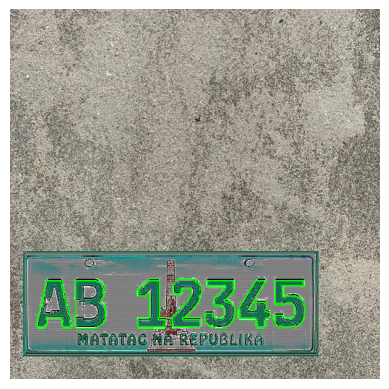

In [70]:
import numpy as np
import cv2
from PIL import Image

def compress(image, annotations, quality=None):
    
    # 1. Handle Input & Alpha Channel
    # We convert to numpy immediately.
    img_array = np.array(image)
    
    alpha_channel = None
    
    # Check if we have transparency (4 channels)
    if img_array.shape[2] == 4:
        # Split RGB and Alpha
        # RGB is img_array[:, :, :3]
        # Alpha is img_array[:, :, 3]
        alpha_channel = img_array[:, :, 3]
        img_rgb = img_array[:, :, :3]
    else:
        img_rgb = img_array

    # 2. Surveillance Defaults
    if quality is None:
        quality = np.random.randint(10, 30)
        subsampling = 2  # 4:2:0 chroma subsampling
        add_scanlines = True
    else:
        subsampling = 2 if quality < 50 else 0
        add_scanlines = False

    # 3. Apply JPEG Compression
    # Note: We only compress the RGB part.
    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    if subsampling > 0:
        encode_param.append(int(cv2.IMWRITE_JPEG_SAMPLING_FACTOR))
        encode_param.append(subsampling)
    
    # Encode and Decode to simulate artifacts
    result, buffer = cv2.imencode('.jpg', img_bgr, encode_param)
    compressed_bgr = cv2.imdecode(buffer, cv2.IMREAD_COLOR)

    # 4. Add Scanline Artifacts
    # We do this on the BGR data before converting back
    if add_scanlines and np.random.random() < 0.3:
        h = compressed_bgr.shape[0]
        # Vectorized scanlines are faster than loops
        # Darken every second row
        compressed_bgr[::2, :, :] = (compressed_bgr[::2, :, :] * 0.85).astype(np.uint8)

    # 5. Add Edge Enhancement
    if np.random.random() < 0.5:
        # Simple sharpening kernel
        kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
        compressed_bgr = cv2.filter2D(compressed_bgr, -1, kernel)

    # 6. Reassemble
    # Convert back to RGB
    compressed_rgb = cv2.cvtColor(compressed_bgr, cv2.COLOR_BGR2RGB)
    
    if alpha_channel is not None:
        # Stack RGB and Alpha back together
        # Axis 2 is the color channel axis
        compressed_rgba = np.dstack((compressed_rgb, alpha_channel))
        final_image = Image.fromarray(compressed_rgba)
    else:
        final_image = Image.fromarray(compressed_rgb)

    return {"image": final_image, "annotations": annotations}

out = compress(
    sample_plate["image"],
    sample_plate["annotations"],
)

out = plate_on_512x512(
    out["image"],
    out["annotations"],
    scale=1.0,
    enable_random_background=True
)

print("Compression")
plot_image(visualize_polygon_overlay(out["image"], out["annotations"]))

To Gray

Grayscale Conversion


Grayscale Conversion


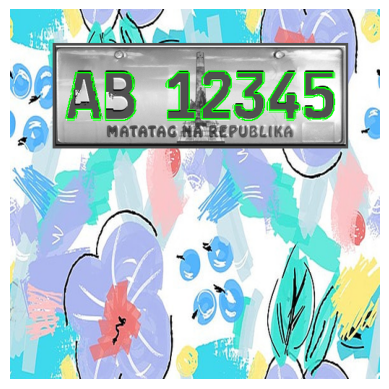

In [71]:
def to_gray(image, annotations):

    if image.mode == "RGBA":
        # Split channels
        r, g, b, a = image.split()
        
        # Convert RGB to grayscale
        grayscale = Image.merge("RGB", (r, g, b)).convert("L")
        
        # Convert back to RGB mode for merging with alpha
        grayscale_rgb = Image.merge("RGB", (grayscale, grayscale, grayscale))
        
        # Merge with original alpha channel
        result = Image.merge("RGBA", (*grayscale_rgb.split(), a))
    else:
        # If no alpha channel, just convert to L and back to RGBA
        result = image.convert("L").convert("RGBA")
    
    return {"image": result, "annotations": annotations}

# Demo: Grayscale Conversion
print("Grayscale Conversion")

out_gray = to_gray(
    sample_plate["image"],
    sample_plate["annotations"]
)

out_gray = plate_on_512x512(
    out_gray["image"],
    out_gray["annotations"],
    scale=1.0,
    enable_random_background=True
)

plot_image(visualize_polygon_overlay(out_gray["image"], out_gray["annotations"]))

For CLAHE (mimics how some Image Signal Processors in cameras try to balance dark shadows and bright highlights)

CLAHE


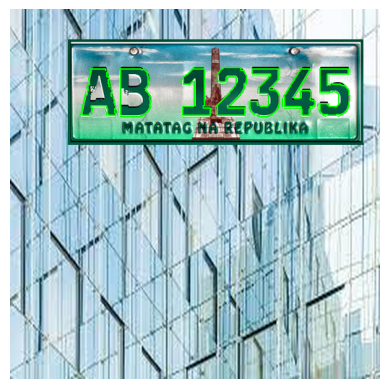

In [72]:
def apply_clahe(image, annotations, clip_limit=None, tile_grid_size=(8, 8)):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to simulate
    camera ISP adjustments. Works on both RGB and grayscale images.
    """
    if image.mode == "RGBA":
        r, g, b, a = image.split()
        rgb_img = Image.merge("RGB", (r, g, b))
    else:
        rgb_img = image.convert("RGB")
        a = None
    
    img_array = np.array(rgb_img)
    
    # Random clip limit if not specified
    if clip_limit is None:
        clip_limit = random.uniform(1.5, 4.0)
    
    # Convert to LAB color space for better results
    lab = cv2.cvtColor(img_array, cv2.COLOR_RGB2LAB)
    l, a_channel, b_channel = cv2.split(lab)
    
    # Apply CLAHE to L channel only
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    l_clahe = clahe.apply(l)
    
    # Merge back
    lab_clahe = cv2.merge([l_clahe, a_channel, b_channel])
    result_rgb = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)
    
    result_image = Image.fromarray(result_rgb)
    
    # Restore alpha channel if present
    if a is not None:
        result_image = Image.merge("RGBA", (*result_image.split(), a))
    else:
        result_image = result_image.convert("RGBA")
    
    return {"image": result_image, "annotations": annotations}

# Demo: CLAHE Effect
print("CLAHE")

out_clahe = apply_clahe(
    sample_plate["image"],
    sample_plate["annotations"]
)

out_clahe = plate_on_512x512(
    out_clahe["image"],
    out_clahe["annotations"],
    scale=1.0,
    enable_random_background=True
)

plot_image(visualize_polygon_overlay(out_clahe["image"], out_clahe["annotations"]))

Aggressive Sharpening (CCTV-style)


Aggressive Sharpening (CCTV-style)


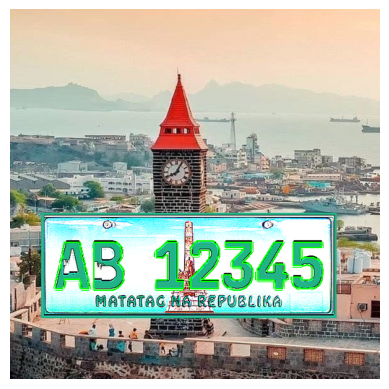

In [73]:
def sharpen(image, annotations, strength=None):
    """
    Apply aggressive sharpening to simulate cheap CCTV camera processing.
    Creates halo artifacts around edges, similar to over-sharpened security footage.
    """
    if image.mode == "RGBA":
        r, g, b, a = image.split()
        rgb_img = Image.merge("RGB", (r, g, b))
    else:
        rgb_img = image.convert("RGB")
        a = None
    
    img_array = np.array(rgb_img)
    
    # Random strength if not specified (higher = more aggressive)
    if strength is None:
        strength = random.uniform(1.5, 3.5)
    
    # Unsharp mask kernel - creates halo effect
    # The center value determines sharpening intensity
    kernel = np.array([
        [-1, -1, -1],
        [-1, 8 + strength, -1],
        [-1, -1, -1]
    ])
    
    # Apply sharpening
    sharpened = cv2.filter2D(img_array, -1, kernel)
    
    # Clip values to valid range
    sharpened = np.clip(sharpened, 0, 255).astype(np.uint8)
    
    result_image = Image.fromarray(sharpened)
    
    # Restore alpha channel if present
    if a is not None:
        result_image = Image.merge("RGBA", (*result_image.split(), a))
    else:
        result_image = result_image.convert("RGBA")
    
    return {"image": result_image, "annotations": annotations}

# Demo: Sharpening Effect
print("Aggressive Sharpening (CCTV-style)")

out_sharpen = sharpen(
    sample_plate["image"],
    sample_plate["annotations"]
)

out_sharpen = plate_on_512x512(
    out_sharpen["image"],
    out_sharpen["annotations"],
    scale=1.0,
    enable_random_background=True
)

plot_image(visualize_polygon_overlay(out_sharpen["image"], out_sharpen["annotations"]))

**Other augmentations like value/brightness can be added within Ultralytics' training loop. We're just gonna add the ones that aren't as easy to augment within our dataset to speed up training.**

## Comprehensive Dataset Generation

We'll generate 10,000 synthetic license plates following Philippine LTO standards while ensuring character balance and diverse augmentations.

**Strategy:**
- 70-80% official format (3 letters + 4 digits)
- 20-30% random formats for character balancing
- 30% clean images, 70% with augmentations
- Uniform distribution of all A-Z, 0-9 characters
- Split into train/val/test (80%/10%/10%)

In [74]:
import threading
import json
import shutil
from collections import Counter
from pathlib import Path

# Dataset configuration
TOTAL_IMAGES = 10000
VALID_FORMAT_RATIO = 0.50  # 50% valid Philippine format (3L+4D), 50% letter-heavy for balance
CLEAN_IMAGE_RATIO = 0.30   # 30% clean, 70% augmented
TRAIN_RATIO = 0.80
VAL_RATIO = 0.10
TEST_RATIO = 0.10

# Output directories
OUTPUT_DIR = Path("dataset")
IMAGES_DIR = OUTPUT_DIR / "images"
LABELS_DIR = OUTPUT_DIR / "labels"
TRAIN_DIR = OUTPUT_DIR / "train"
VAL_DIR = OUTPUT_DIR / "val"
TEST_DIR = OUTPUT_DIR / "test"

# Create directory structure
for dir_path in [TRAIN_DIR / "images", TRAIN_DIR / "labels",
                 VAL_DIR / "images", VAL_DIR / "labels",
                 TEST_DIR / "images", TEST_DIR / "labels"]:
    dir_path.mkdir(parents=True, exist_ok=True)

print("Dataset directories created successfully!")
print(f"Output directory: {OUTPUT_DIR.absolute()}")

Dataset directories created successfully!
Output directory: c:\Users\lifei\OneDrive\Desktop\CSC173 - Intelligent Systems\CSC173-DeepCV-Sanchez\dataset


In [ ]:
# Character balancing utilities
class CharacterBalancer:
    """Tracks character usage and generates balanced plate text."""
    
    def __init__(self):
        self.letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
        self.digits = list("0123456789")
        self.letter_counts = Counter()
        self.digit_counts = Counter()
        self.lock = threading.Lock()
    
    def generate_valid_format(self):
        """Generate valid Philippine format: 3 letters + 4 digits (e.g., ABC 1234)"""
        # Pick underrepresented letters
        with self.lock:
            # Sort by count, take from least used
            sorted_letters = sorted(self.letters, key=lambda x: self.letter_counts[x])
            sorted_digits = sorted(self.digits, key=lambda x: self.digit_counts[x])
            
            # Select 3 letters and 4 digits, biased toward underrepresented
            letters = random.choices(sorted_letters[:13], k=3)  # Top half underrepresented
            digits = random.choices(sorted_digits[:5], k=4)     # Top half underrepresented
            
            # Update counts
            for letter in letters:
                self.letter_counts[letter] += 1
            for digit in digits:
                self.digit_counts[digit] += 1
        
        text = ''.join(letters) + ' ' + ''.join(digits)
        return text
    
    def generate_random_format(self):
        """Generate random format to balance character distribution."""
        formats = [
            # Various random patterns
            lambda: ''.join(random.choices(self.letters, k=4)) + ' ' + ''.join(random.choices(self.digits, k=3)),
            lambda: ''.join(random.choices(self.letters, k=2)) + ' ' + ''.join(random.choices(self.digits, k=5)),
            lambda: ''.join(random.choices(self.letters, k=5)) + ' ' + ''.join(random.choices(self.digits, k=2)),
            lambda: ''.join(random.choices(self.digits, k=2)) + ' ' + ''.join(random.choices(self.letters, k=3)) + ' ' + ''.join(random.choices(self.digits, k=2)),
            lambda: ''.join([random.choice(self.letters + self.digits) for _ in range(7)]),
            lambda: ''.join(random.choices(self.letters, k=6)) + ' ' + random.choice(self.digits),
            lambda: random.choice(self.digits) + ' ' + ''.join(random.choices(self.letters, k=6)),
        ]
        
        text = random.choice(formats)()
        
        # Update counts
        with self.lock:
            for char in text.replace(' ', ''):
                if char in self.letters:
                    self.letter_counts[char] += 1
                elif char in self.digits:
                    self.digit_counts[char] += 1
        
        return text
    
    def get_stats(self):
        """Return character distribution statistics."""
        with self.lock:
            return {
                "letters": dict(self.letter_counts),
                "digits": dict(self.digit_counts),
                "letter_mean": np.mean(list(self.letter_counts.values())) if self.letter_counts else 0,
                "digit_mean": np.mean(list(self.digit_counts.values())) if self.digit_counts else 0,
                "letter_std": np.std(list(self.letter_counts.values())) if self.letter_counts else 0,
                "digit_std": np.std(list(self.digit_counts.values())) if self.digit_counts else 0,
            }

# Initialize balancer
char_balancer = CharacterBalancer()
print("Character balancer initialized!")

Character balancer initialized!


In [76]:
def generate_single_plate(idx, use_valid_format, apply_augmentations):
    """Generate a single license plate image with annotations."""
    try:
        # Generate plate text
        if use_valid_format:
            plate_text = char_balancer.generate_valid_format()
        else:
            plate_text = char_balancer.generate_random_format()
        
        # Select random plate style
        style_type, color1, color2 = random.choice(plate_styles)
        font = random.choice(fonts)
        
        # Enable paint chipping randomly
        enable_chipping = random.random() < 0.5
        
        # Create base plate based on style
        if style_type == "vehicle":
            plate_data = create_vehicle_plate(
                color1, color2, font, plate_text,
                enable_paint_chipping=enable_chipping,
                enable_small_text=random.random() < 0.7
            )
        elif style_type == "motorcycle":
            plate_data = create_motorcycle_plate(
                color2, font, plate_text,
                detailOnTop=random.random() < 0.5,
                enable_paint_chipping=enable_chipping
            )
        elif style_type == "motorcycle_beveled":
            plate_data = create_motorcycle_beveled_plate(
                color1, color2, font, plate_text,
                enable_paint_chipping=enable_chipping,
                enable_small_text=random.random() < 0.7
            )
        elif style_type == "government":
            # Government uses vehicle format
            plate_data = create_vehicle_plate(
                color1, color2, font, plate_text,
                enable_paint_chipping=enable_chipping,
                enable_small_text=random.random() < 0.7
            )
        elif style_type == "rizal":
            plate_data = create_rizal_plate(
                font, plate_text,
                enable_paint_chipping=enable_chipping
            )
        else:
            # Fallback to vehicle
            plate_data = create_vehicle_plate(
                white, black, font, plate_text,
                enable_paint_chipping=enable_chipping
            )
        
        # Apply augmentations if needed
        if apply_augmentations:
            # Randomly select augmentation pipeline
            aug_choice = random.random()
            
            # Perspective transform (50% chance)
            if random.random() < 0.5:
                plate_data = perspective_transform(
                    plate_data["image"],
                    plate_data["annotations"],
                    max_warp=random.uniform(0.05, 0.25)
                )
            
            # Rotation (40% chance)
            if random.random() < 0.4:
                plate_data = rotate_transform(
                    plate_data["image"],
                    plate_data["annotations"],
                    max_angle=random.uniform(5, 20)
                )
            
            # Motion blur (30% chance)
            if random.random() < 0.3:
                plate_data = motion_blur(
                    plate_data["image"],
                    plate_data["annotations"],
                    length=random.randint(10, 25),
                    angle=random.randint(0, 360),
                    num_samples=random.randint(5, 15)
                )
            
            # Plate obscuration (25% chance)
            if random.random() < 0.25 and plate_obscuration_files:
                plate_data["image"] = apply_plate_obscuration(plate_data["image"])
            
            # Compression (60% chance)
            if random.random() < 0.6:
                plate_data = compress(
                    plate_data["image"],
                    plate_data["annotations"],
                    quality=random.randint(10, 40)
                )
            
            # Grayscale (20% chance)
            if random.random() < 0.2:
                plate_data = to_gray(
                    plate_data["image"],
                    plate_data["annotations"]
                )
            
            # CLAHE (35% chance)
            if random.random() < 0.35:
                plate_data = apply_clahe(
                    plate_data["image"],
                    plate_data["annotations"],
                    clip_limit=random.uniform(1.5, 4.0)
                )
            
            # Sharpening (25% chance)
            if random.random() < 0.25:
                plate_data = sharpen(
                    plate_data["image"],
                    plate_data["annotations"],
                    strength=random.uniform(1.5, 3.5)
                )
        
        # Place on 512x512 canvas with random background
        final_data = plate_on_512x512(
            plate_data["image"],
            plate_data["annotations"],
            scale=random.uniform(0.7, 1.0),
            enable_random_background=random.random() < 0.8
        )
        
        return {
            "index": idx,
            "text": plate_text,
            "image": final_data["image"],
            "annotations": final_data["annotations"],
            "style": style_type,
            "augmented": apply_augmentations
        }
        
    except Exception as e:
        print(f"Error generating plate {idx}: {e}")
        return None

print("Plate generation function defined!")

Plate generation function defined!


In [77]:
def save_plate_data(plate_data, split="train"):
    """Save plate image and YOLO format annotations."""
    if plate_data is None:
        return False
    
    try:
        idx = plate_data["index"]
        split_dir = OUTPUT_DIR / split
        
        # Save image
        img_path = split_dir / "images" / f"plate_{idx:06d}.png"
        plate_data["image"].convert("RGB").save(img_path, "PNG")
        
        # Save YOLO format labels
        label_path = split_dir / "labels" / f"plate_{idx:06d}.txt"
        
        img_width, img_height = plate_data["image"].size
        
        with open(label_path, "w") as f:
            for ann in plate_data["annotations"]:
                char = ann["character"]
                mask = np.array(ann["mask"])
                
                # Find bounding box from mask
                rows = np.any(mask, axis=1)
                cols = np.any(mask, axis=0)
                
                if not rows.any() or not cols.any():
                    continue
                
                y_min, y_max = np.where(rows)[0][[0, -1]]
                x_min, x_max = np.where(cols)[0][[0, -1]]
                
                # Convert to YOLO format (normalized center x, center y, width, height)
                x_center = (x_min + x_max) / 2 / img_width
                y_center = (y_min + y_max) / 2 / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height
                
                # Character to class ID (A-Z: 0-25, 0-9: 26-35)
                if char.isalpha():
                    class_id = ord(char.upper()) - ord('A')
                elif char.isdigit():
                    class_id = 26 + int(char)
                else:
                    continue  # Skip non-alphanumeric
                
                # Write YOLO format: class_id x_center y_center width height
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\\n")
        
        return True
        
    except Exception as e:
        print(f"Error saving plate {plate_data['index']}: {e}")
        return False

print("Save function defined!")

Save function defined!


In [78]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm
import time

def generate_dataset():
    """Generate the complete dataset with multithreading."""
    
    print(f"\\n{'='*60}")
    print(f"Starting Dataset Generation")
    print(f"{'='*60}")
    print(f"Total images: {TOTAL_IMAGES}")
    print(f"Valid format: {int(TOTAL_IMAGES * VALID_FORMAT_RATIO)} ({VALID_FORMAT_RATIO*100:.0f}%)")
    print(f"Random format: {int(TOTAL_IMAGES * (1-VALID_FORMAT_RATIO))} ({(1-VALID_FORMAT_RATIO)*100:.0f}%)")
    print(f"Clean images: {int(TOTAL_IMAGES * CLEAN_IMAGE_RATIO)} ({CLEAN_IMAGE_RATIO*100:.0f}%)")
    print(f"Augmented images: {int(TOTAL_IMAGES * (1-CLEAN_IMAGE_RATIO))} ({(1-CLEAN_IMAGE_RATIO)*100:.0f}%)")
    print(f"{'='*60}\\n")
    
    # Determine format and augmentation for each image
    indices = list(range(TOTAL_IMAGES))
    random.shuffle(indices)
    
    # Split indices
    train_count = int(TOTAL_IMAGES * TRAIN_RATIO)
    val_count = int(TOTAL_IMAGES * VAL_RATIO)
    
    train_indices = indices[:train_count]
    val_indices = indices[train_count:train_count + val_count]
    test_indices = indices[train_count + val_count:]
    
    print(f"Split distribution:")
    print(f"  Train: {len(train_indices)} images")
    print(f"  Val:   {len(val_indices)} images")
    print(f"  Test:  {len(test_indices)} images\\n")
    
    # Prepare generation parameters
    valid_count = int(TOTAL_IMAGES * VALID_FORMAT_RATIO)
    augmented_count = int(TOTAL_IMAGES * (1 - CLEAN_IMAGE_RATIO))
    
    # Assign format types
    format_indices = indices.copy()
    random.shuffle(format_indices)
    valid_format_set = set(format_indices[:valid_count])
    
    # Assign augmentation
    aug_indices = indices.copy()
    random.shuffle(aug_indices)
    augmented_set = set(aug_indices[:augmented_count])
    
    # Thread-safe counters
    success_count = [0]
    lock = threading.Lock()
    
    def process_plate(idx):
        """Process a single plate and save it."""
        # Determine split
        if idx in train_indices:
            split = "train"
        elif idx in val_indices:
            split = "val"
        else:
            split = "test"
        
        # Generate plate
        plate_data = generate_single_plate(
            idx,
            use_valid_format=(idx in valid_format_set),
            apply_augmentations=(idx in augmented_set)
        )
        
        # Save plate
        if plate_data and save_plate_data(plate_data, split=split):
            with lock:
                success_count[0] += 1
            return True
        return False
    
    # Multi-threaded generation
    start_time = time.time()
    
    # Use ThreadPoolExecutor for parallel processing
    max_workers = min(32, (os.cpu_count() or 1) * 4)  # Adjust based on system
    print(f"Using {max_workers} worker threads\\n")
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = {executor.submit(process_plate, idx): idx for idx in indices}
        
        # Progress bar
        with tqdm(total=TOTAL_IMAGES, desc="Generating plates", unit="img") as pbar:
            for future in as_completed(futures):
                pbar.update(1)
    
    elapsed_time = time.time() - start_time
    
    print(f"\\n{'='*60}")
    print(f"Dataset Generation Complete!")
    print(f"{'='*60}")
    print(f"Successfully generated: {success_count[0]}/{TOTAL_IMAGES} images")
    print(f"Time elapsed: {elapsed_time:.2f} seconds")
    print(f"Average time per image: {elapsed_time/TOTAL_IMAGES:.3f} seconds")
    print(f"{'='*60}\\n")
    
    # Character distribution statistics
    stats = char_balancer.get_stats()
    print(f"Character Distribution Statistics:")
    print(f"  Letters - Mean: {stats['letter_mean']:.1f}, Std Dev: {stats['letter_std']:.1f}")
    print(f"  Digits  - Mean: {stats['digit_mean']:.1f}, Std Dev: {stats['digit_std']:.1f}")
    
    return success_count[0]

print("Dataset generation function ready!")

Dataset generation function ready!


c:\Users\lifei\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset configuration saved to: dataset\data.yaml
\nDataset ready! YAML file created at: dataset\data.yaml\n


### Generate the Dataset

Run this cell to generate the complete dataset. This will take several minutes depending on your system.

**Note:** The generation uses multithreading for efficiency. Progress will be displayed with a progress bar.

In [ ]:
# Generate the dataset
success_count = generate_dataset()

\n============================================================
Starting Dataset Generation
Total images: 10000
Valid format: 7500 (75%)
Random format: 2500 (25%)
Clean images: 3000 (30%)
Augmented images: 7000 (70%)
============================================================\n
Split distribution:
  Train: 8000 images
  Val:   1000 images
  Test:  1000 images\n
Using 16 worker threads\n


\n============================================================
Starting Dataset Generation
Total images: 10000
Valid format: 7500 (75%)
Random format: 2500 (25%)
Clean images: 3000 (30%)
Augmented images: 7000 (70%)
============================================================\n
Split distribution:
  Train: 8000 images
  Val:   1000 images
  Test:  1000 images\n
Using 16 worker threads\n


Generating plates:  99%|█████████▉| 9881/10000 [26:54<00:22,  5.40img/s]  

### Visualize Sample Results

Let's examine some generated plates from each split to verify quality.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_yolo_annotations(image_path, label_path):
    """Visualize YOLO format annotations on image."""
    # Load image
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    # Load labels
    boxes = []
    class_names = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789")
    
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id, x_center, y_center, width, height = map(float, parts)
                boxes.append({
                    'class_id': int(class_id),
                    'class_name': class_names[int(class_id)],
                    'x_center': x_center,
                    'y_center': y_center,
                    'width': width,
                    'height': height
                })
    
    # Plot
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)
    
    # Draw bounding boxes
    for box in boxes:
        # Convert normalized coordinates to pixel coordinates
        x_center = box['x_center'] * img_width
        y_center = box['y_center'] * img_height
        w = box['width'] * img_width
        h = box['height'] * img_height
        
        # Calculate top-left corner
        x = x_center - w / 2
        y = y_center - h / 2
        
        # Create rectangle
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor='lime',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(
            x, y - 5,
            box['class_name'],
            color='lime',
            fontsize=12,
            weight='bold',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.7)
        )
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize samples from each split
for split in ['train', 'val', 'test']:
    split_img_dir = OUTPUT_DIR / split / "images"
    split_label_dir = OUTPUT_DIR / split / "labels"
    
    # Get a few random samples
    image_files = list(split_img_dir.glob("*.png"))
    
    if image_files:
        print(f"\\n{split.upper()} Split Samples:")
        print("="*60)
        
        # Show 3 random samples
        samples = random.sample(image_files, min(3, len(image_files)))
        
        for img_path in samples:
            label_path = split_label_dir / f"{img_path.stem}.txt"
            
            if label_path.exists():
                print(f"\\nImage: {img_path.name}")
                visualize_yolo_annotations(img_path, label_path)

### Dataset Statistics and Analysis

Analyze the character distribution and dataset composition.

In [ ]:
import matplotlib.pyplot as plt

# Get final character distribution
stats = char_balancer.get_stats()

# Plot character distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Letters distribution
letters = sorted(stats['letters'].items())
letter_chars = [x[0] for x in letters]
letter_counts = [x[1] for x in letters]

ax1.bar(letter_chars, letter_counts, color='steelblue', alpha=0.7)
ax1.axhline(y=stats['letter_mean'], color='red', linestyle='--', 
            label=f"Mean: {stats['letter_mean']:.1f}")
ax1.set_xlabel('Letters', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title(f'Letter Distribution (Std Dev: {stats["letter_std"]:.1f})', fontsize=14)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Digits distribution
digits = sorted(stats['digits'].items())
digit_chars = [x[0] for x in digits]
digit_counts = [x[1] for x in digits]

ax2.bar(digit_chars, digit_counts, color='coral', alpha=0.7)
ax2.axhline(y=stats['digit_mean'], color='red', linestyle='--',
            label=f"Mean: {stats['digit_mean']:.1f}")
ax2.set_xlabel('Digits', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Digit Distribution (Std Dev: {stats["digit_std"]:.1f})', fontsize=14)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\\n" + "="*60)
print("DATASET STATISTICS SUMMARY")
print("="*60)

for split in ['train', 'val', 'test']:
    split_dir = OUTPUT_DIR / split / "images"
    img_count = len(list(split_dir.glob("*.png")))
    print(f"{split.capitalize():6s}: {img_count:5d} images")

print("="*60)
print(f"Total:  {TOTAL_IMAGES:5d} images")
print("="*60)

print(f"\\nCharacter Balance:")
print(f"  Letters: Mean={stats['letter_mean']:.1f}, StdDev={stats['letter_std']:.1f}")
print(f"  Digits:  Mean={stats['digit_mean']:.1f}, StdDev={stats['digit_std']:.1f}")

# Calculate coefficient of variation (lower is better)
letter_cv = (stats['letter_std'] / stats['letter_mean']) * 100 if stats['letter_mean'] > 0 else 0
digit_cv = (stats['digit_std'] / stats['digit_mean']) * 100 if stats['digit_mean'] > 0 else 0

print(f"\\nCoefficient of Variation (lower = better balance):")
print(f"  Letters: {letter_cv:.1f}%")
print(f"  Digits:  {digit_cv:.1f}%")

if letter_cv < 20 and digit_cv < 20:
    print(f"\\nExcellent character balance achieved!")
elif letter_cv < 30 and digit_cv < 30:
    print(f"\\nGood character balance achieved!")
else:
    print(f"\\nCharacter distribution could be improved. Consider regenerating with adjusted parameters.")

print(f"\\nDataset is ready for training!")
print(f"Use the following path in your training script:")
print(f"  {(OUTPUT_DIR / 'data.yaml').absolute()}")